# Planets Model

## Load Libs


In [2]:
import ast
import os
import re
from datetime import datetime as dt

import icecream
import numpy as np
import pandas as pd
import torch
from icecream import ic
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast

import hephaestus as hp
from hephaestus.models import TimeSeriesDecoder

# %%
torch.set_default_dtype(torch.float32)
# %%
icecream.install()
ic_disable = True  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
# pd.options.mode.copy_on_write = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    print("MPS available")
else:
    print("CUDA not available. Checking why...")
    import os

    print(f"CUDA_VISIBLE_DEVICES: {os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set')}")

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.4
GPU device: NVIDIA GH200 480GB


We use BERT tokenizer to tokenize the text data.


In [4]:
model_name = "bert-base-uncased"
model = BertModel.from_pretrained(
    "bert-base-uncased", torch_dtype=torch.float32, attn_implementation="sdpa"
)
tokenizer = BertTokenizerFast.from_pretrained(model_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Load Data

We use `line2df` to load the original data from
[PolyMathic](https://polymathic-ai.org/blog/xval/). Since we've already transformed the
data into a parquet file, we can load it directly.


In [5]:
def line2df(line, idx):
    data_rows = []
    line = ast.literal_eval(line)
    for i, time_step in enumerate(line["data"]):
        row = {"time_step": i}
        # Add position data for each planet
        for j, position in enumerate(time_step):
            row[f"planet{j}_x"] = position[0]
            row[f"planet{j}_y"] = position[1]
        data_rows.append(row)

    df = pd.DataFrame(data_rows)
    description = line.pop("description")
    step_size = description.pop("stepsize")
    for k, v in description.items():
        for k_prop, v_prop in v.items():
            df[f"{k}_{k_prop}"] = v_prop
    df["time_step"] = df["time_step"] * step_size
    df.insert(0, "idx", idx)

    return df

In [6]:
files = os.listdir("data")
if "planets.parquet" not in files:
    with open("data/planets.data") as f:
        data = f.read().splitlines()

        dfs = []
        for idx, line in enumerate(tqdm(data)):
            dfs.append(line2df(line, idx))
        df = pd.concat(dfs)
    df.to_parquet("data/planets.parquet")
else:
    df = pd.read_parquet("data/planets.parquet")


# Combine total mass of all planets into one column `planet<n>_m`
mass_regex = re.compile(r"planet(\d+)_m")
mass_cols = [col for col in df.columns if mass_regex.match(col)]
df["total_mass"] = df[mass_cols].sum(axis=1)
# Introduce categorical columns for the number of planets choose non null columns with mass
df["n_planets"] = df[mass_cols].notnull().sum(axis=1).astype("object")
df["n_planets"] = df["n_planets"].apply(lambda x: f"{x}_planets")
# Create category acceleration if the sum of plane/d_[x,y, z] is greater than 0
df["acceleration_x"] = df[
    [col for col in df.columns if "planet" in col and "_x" in col]
].sum(axis=1)
# Set acceleration_x to "increasing" if greater than 0 else "decreasing"
df["acceleration_x"] = (
    df["acceleration_x"]
    .apply(lambda x: "increasing" if x > 0 else "decreasing")
    .astype("object")
)
df["acceleration_y"] = df[
    [col for col in df.columns if "planet" in col and "_y" in col]
].sum(axis=1)
df["acceleration_y"] = df["acceleration_y"].apply(
    lambda x: "increasing" if x > 0 else "decreasing"
)


df.describe()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
count,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,4.165044e+06,4.165044e+06,5.563957e+06,5.563957e+06,...,2.783627e+06,2.783627e+06,2.783627e+06,2.783627e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,5.563957e+06
mean,6.248635e+04,9.748911e+00,-1.339198e-01,7.391138e-02,-1.340140e-01,7.291389e-02,-1.305344e-01,7.065633e-02,2.999306e+00,1.624756e+00,...,6.559150e-02,2.996303e+00,1.623874e+00,9.980576e-01,-1.276881e-01,6.519469e-02,3.002531e+00,1.625815e+00,1.001317e+00,1.049149e+01
std,3.607949e+04,5.993534e+00,1.228071e+00,1.213232e+00,1.227950e+00,1.212650e+00,1.217229e+00,1.203678e+00,1.157182e+00,5.876632e-01,...,1.200148e+00,1.153190e+00,5.270725e-01,5.764675e-01,1.211648e+00,1.199625e+00,1.156856e+00,5.167198e-01,5.779763e-01,3.991780e+00
min,0.000000e+00,0.000000e+00,-3.294763e+00,-2.997514e+00,-3.284004e+00,-2.998546e+00,-3.289790e+00,-2.998050e+00,1.000003e+00,1.000000e+00,...,-2.997621e+00,1.000054e+00,1.000000e+00,9.369537e-05,-3.273603e+00,-2.998913e+00,1.000103e+00,1.000000e+00,6.720938e-05,2.014597e+00
25%,3.124400e+04,4.655172e+00,-1.030131e+00,-9.020907e-01,-1.030516e+00,-9.028009e-01,-1.050662e+00,-9.211662e-01,1.993948e+00,1.000000e+00,...,-9.321272e-01,1.996853e+00,1.191548e+00,4.980967e-01,-1.071974e+00,-9.394428e-01,2.004240e+00,1.215927e+00,5.032645e-01,7.282371e+00
50%,6.249100e+04,9.523810e+00,-1.542335e-01,1.117099e-01,-1.538916e-01,1.099474e-01,-1.525520e-01,1.118031e-01,2.994477e+00,1.543047e+00,...,1.067355e-01,3.001879e+00,1.535683e+00,9.955040e-01,-1.507184e-01,1.055276e-01,3.000454e+00,1.519040e+00,1.003118e+00,1.028205e+01
75%,9.372800e+04,1.440000e+01,8.583344e-01,9.784987e-01,8.581045e-01,9.783998e-01,8.762358e-01,9.912902e-01,4.005747e+00,2.020672e+00,...,9.956064e-01,3.986406e+00,1.969644e+00,1.497746e+00,8.906780e-01,9.991220e-01,4.003332e+00,1.950518e+00,1.503457e+00,1.345633e+01
max,1.249990e+05,2.400000e+01,2.996370e+00,2.999014e+00,2.993319e+00,2.999536e+00,2.990464e+00,2.998478e+00,4.999994e+00,2.999984e+00,...,3.000881e+00,4.999990e+00,2.999909e+00,1.999957e+00,2.985180e+00,2.998936e+00,4.999679e+00,2.999497e+00,1.999999e+00,2.382455e+01


In [7]:
df.head()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass,n_planets,acceleration_x,acceleration_y
0,0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
1,0,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
2,0,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
3,0,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
4,0,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing


In [8]:
df_categorical = df.select_dtypes(include=["object"]).astype(str)
unique_values_per_column = df_categorical.apply(
    pd.Series.unique
).values  # .flatten().tolist()
flattened_unique_values = np.concatenate(unique_values_per_column).tolist()
unique_values = list(set(flattened_unique_values))
unique_values

['increasing',
 '2_planets',
 'decreasing',
 '3_planets',
 '4_planets',
 '5_planets']

In [9]:
df.select_dtypes(include="object").groupby(
    df.select_dtypes(include="object").columns.tolist()
).size().reset_index(name="count")

,n_planets,acceleration_x,acceleration_y,count
0,2_planets,decreasing,decreasing,365720
1,2_planets,decreasing,increasing,410992
2,2_planets,increasing,decreasing,272240
3,2_planets,increasing,increasing,349961
4,3_planets,decreasing,decreasing,410092
5,3_planets,decreasing,increasing,404513
6,3_planets,increasing,decreasing,258536
7,3_planets,increasing,increasing,308276
8,4_planets,decreasing,decreasing,413451
9,4_planets,decreasing,increasing,416444


In [10]:
df = df.reset_index(drop=True)
# df = df.head(
#     5_000
# )  # For testing purposes only, train on the full dataset in production

In [11]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(99999, 25001)

In [12]:
N_HEADS = 8 * 4
tabular_decoder = TimeSeriesDecoder(time_series_config, d_model=512, n_heads=N_HEADS)

In [13]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

batch_size = 64

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    collate_fn=hp.tabular_collate_fn,
    pin_memory=True if torch.cuda.is_available() else False,
)
tabular_decoder = tabular_decoder.to(device)  # Move model to device first

# Create a sample batch from the training dataset
example_batch = train_ds[0:6]
numeric_data = example_batch.numeric.to(device)
categorical_data = example_batch.categorical.to(device)

Using device: cuda


In [14]:
with torch.no_grad():
    prediction = tabular_decoder(numeric_data, categorical_data)

    # Move predictions back to CPU for numpy operations if needed
    prediction = prediction.to("cpu")

    prediction.numeric = prediction.numeric.transpose(1, 2)
    prediction.categorical = prediction.categorical.permute(0, 2, 1, 3)


# Print prediction summary instead of all values
print("Prediction numeric shape:", prediction.numeric.shape)
print("Prediction categorical shape:", prediction.categorical.shape)
print(
    "Prediction contains NaN (numeric):",
    torch.isnan(prediction.numeric).any().item(),
)
print(
    "Prediction contains NaN (categorical):",
    torch.isnan(prediction.categorical).any().item(),
)

Prediction numeric shape: torch.Size([6, 59, 27])
Prediction categorical shape: torch.Size([6, 59, 3, 41])
Prediction contains NaN (numeric): False
Prediction contains NaN (categorical): False


In [15]:
ic.disable()

In [16]:
def init_weights(m):
    if hasattr(m, "weight") and m.weight is not None:
        if len(m.weight.shape) > 1:
            # Use Kaiming initialization for better stability
            torch.nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
            # Scale down initial weights to prevent explosions
            m.weight.data *= 0.05
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.zeros_(m.bias)


# Apply custom weight initialization
tabular_decoder.apply(init_weights)
# print("Applied conservative weight initialization")

# Move model to device
tabular_decoder.to(device)

# Set up training parameters with much more conservative values
learning_rate = 1e-3  # Reduced learning rate by 5x
num_epochs = 2
gradient_accumulation_steps = 4  # Increased for stability
max_grad_norm = 0.1  # Much tighter gradient clipping

# Add gradient explosion detection threshold
max_gradient_norm_allowed = 10.0
max_explosion_count = 5  # Allow this many explosions before reducing LR permanently

timestamp = dt.now().strftime("%Y-%m-%dT%H-%M-%S")
model_name = "BetterAttention"
log_dir = f"runs/{timestamp}_Heads_{N_HEADS}_Batch_{batch_size}_{model_name}"
save_dir = "images/planets"

# Ensure log directory exists
os.makedirs(log_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)
print(f"TensorBoard logs will be saved to: {log_dir}")
print("To view logs, run: tensorboard --logdir=runs")
writer = SummaryWriter(log_dir)
# Train the model with enhanced stability parameters
history = hp.train_model(
    model=tabular_decoder,
    train_dataset=train_ds,
    val_dataset=test_ds,
    batch_size=batch_size,  # Reduced batch size for stability
    epochs=num_epochs,
    learning_rate=learning_rate,
    log_dir=log_dir,
    save_dir=save_dir,
    device=device,
    gradient_accumulation_steps=gradient_accumulation_steps,
    max_grad_norm=max_grad_norm,
    explosion_threshold=max_gradient_norm_allowed,
    max_explosions_per_epoch=max_explosion_count,
    writer=writer,
)

TensorBoard logs will be saved to: runs/2025-03-09T18-28-59_Heads_32_Batch_64_BetterAttention
To view logs, run: tensorboard --logdir=runs
Starting loop in hephaestus.training.training_loop.py
Using device: cuda
TensorBoard log directory: runs/2025-03-09T18-28-59_Heads_32_Batch_64_BetterAttention
Epoch 1/2


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/2 completed in 670.86s
Train Loss: 0.7774, Val Loss: 0.3554
Train Numeric Loss: 0.5122, Val Numeric Loss: 0.0802
Train Cat Loss: 0.2651, Val Cat Loss: 0.2752
Current learning rate: 9.09e-04
--------------------------------------------------
Epoch 2/2


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/2 completed in 668.22s
Train Loss: 0.2697, Val Loss: 0.2593
Train Numeric Loss: 0.0382, Val Numeric Loss: 0.0263
Train Cat Loss: 0.2315, Val Cat Loss: 0.2329
Current learning rate: 6.68e-04
--------------------------------------------------
Training completed! TensorBoard logs saved to runs/2025-03-09T18-28-59_Heads_32_Batch_64_BetterAttention
To view training metrics, run:
tensorboard --logdir=runs


In [17]:
df_comp = hp.show_results_df(
    model=tabular_decoder,
    time_series_config=time_series_config,
    dataset=train_ds,
    idx=0,
)

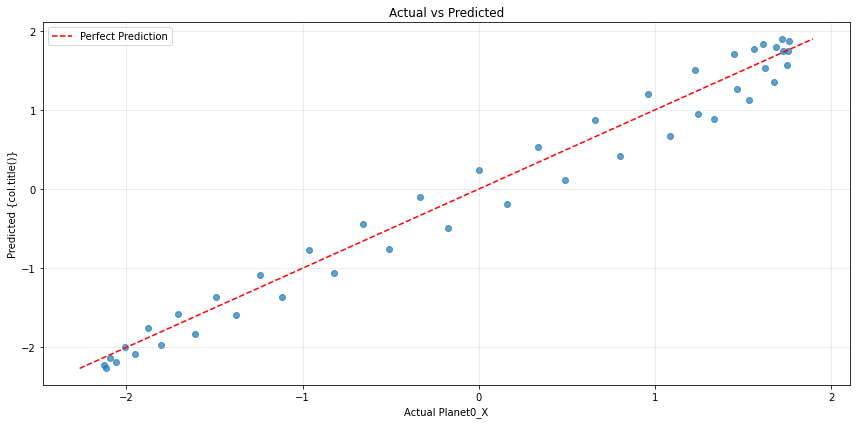

In [18]:
hp.plot_col_error(df_comp, "planet0_x")

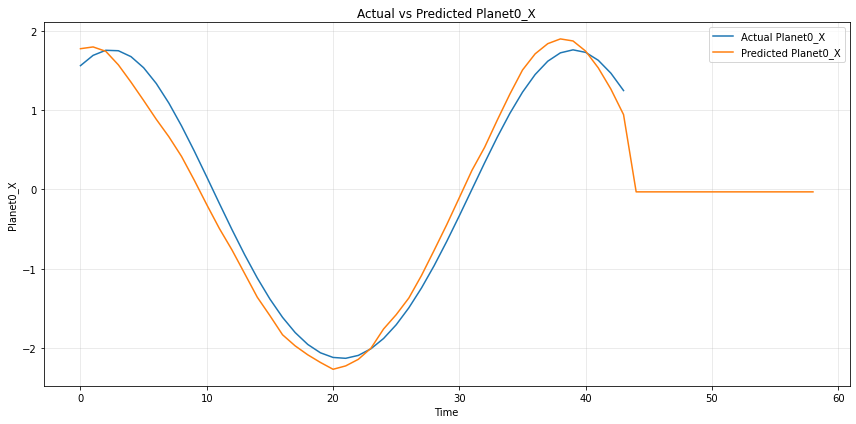

In [19]:
hp.plot_col_comparison(df_comp, "planet0_x")

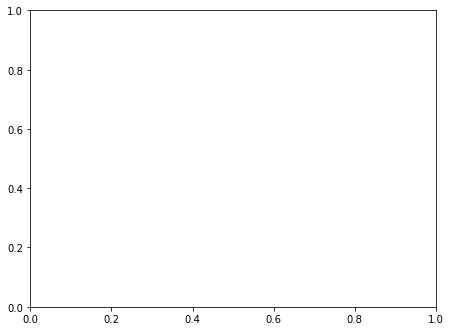

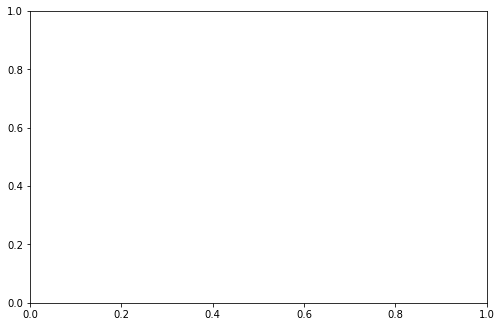

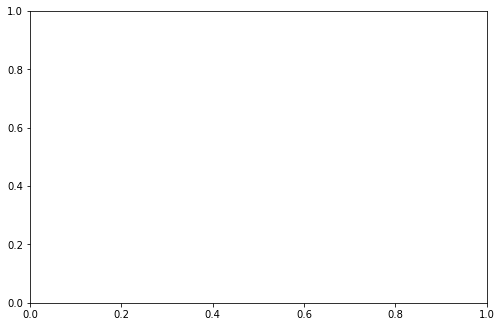

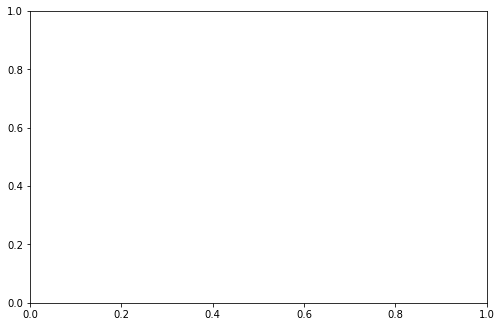

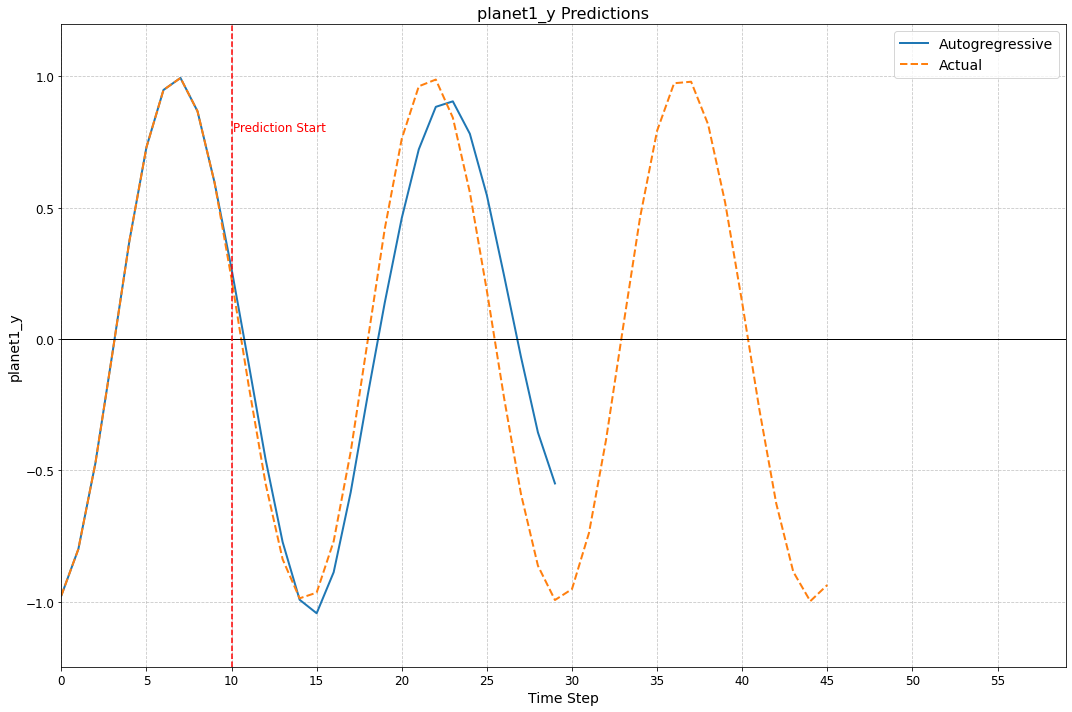

In [27]:
import matplotlib.pyplot as plt
from hephaestus.analysis.analysis import (
    AutoRegressiveResults,
    # auto_regressive_predictions,
    plot_column_variants,
    create_test_inputs_df,
)


def auto_regressive_predictions(
    model, inputs: AutoRegressiveResults, device: str = "cuda"
) -> AutoRegressiveResults:
    """Generate auto-regressive predictions.

    Args:
        model: The model to generate predictions from.
        inputs (AutoRegressiveResults): The inputs for auto-regressive predictions.

    Returns:
        AutoRegressiveResults: The updated inputs.
    """
    model.eval()
    numeric_inputs = inputs.numeric_inputs
    categorical_inputs = inputs.categorical_inputs
    numeric_inputs = numeric_inputs.to(device)
    categorical_inputs = categorical_inputs.to(device)

    # Ensure 3D shape (batch, features, time)
    if numeric_inputs.dim() == 2:
        numeric_inputs = numeric_inputs.unsqueeze(0)
        categorical_inputs = categorical_inputs.unsqueeze(0)

    # Track nan columns
    numeric_nan_columns = torch.isnan(numeric_inputs).all(dim=2)
    categorical_nan_columns = torch.isnan(categorical_inputs).all(dim=2)

    # Get model predictions
    with torch.no_grad():
        outputs = model(
            numeric_inputs=numeric_inputs, categorical_inputs=categorical_inputs
        )

    # Handle numeric predictions
    numeric_next = outputs["numeric"][:, :, -1:]  # Shape: (batch, features, 1)

    # Handle categorical predictions
    categorical_out = outputs["categorical"]  # Shape: (batch, features, time, classes)
    categorical_last = categorical_out[:, :, -1]  # Shape: (batch, features, classes)
    categorical_next = torch.argmax(
        categorical_last, dim=-1
    )  # Shape: (batch, features)
    # Reshape to match input dimensions (batch, features, 1)
    categorical_next = categorical_next.unsqueeze(-1)  # Add time dimension

    # Ensure categorical_next has the same batch and feature dimensions as categorical_inputs
    categorical_next = categorical_next.expand(
        categorical_inputs.shape[0], categorical_inputs.shape[1], 1
    )

    # Concatenate new predictions
    numeric_inputs = torch.cat([numeric_inputs, numeric_next], dim=2)
    categorical_inputs = torch.cat(
        [categorical_inputs, categorical_next.to(torch.float32)], dim=2
    )

    # Restore nan values
    numeric_inputs[numeric_nan_columns] = float("nan")
    categorical_inputs[categorical_nan_columns] = float("nan")

    return AutoRegressiveResults(numeric_inputs, categorical_inputs)


# Generate auto-regressive predictions for the model

# Create initial inputs from the test dataset
test_idx = 5  # Choose a test sample
stop_idx = 10  # Start predictions after this timestep
inputs = AutoRegressiveResults.from_ds(test_ds, test_idx, stop_idx=stop_idx)

# Generate predictions for multiple steps
num_prediction_steps = 20
for _ in range(num_prediction_steps):
    inputs = auto_regressive_predictions(tabular_decoder, inputs)

# Process the results into DataFrames for analysis
actual_inputs = test_ds[test_idx]
actual_df = create_test_inputs_df(
    AutoRegressiveResults(actual_inputs.numeric, actual_inputs.categorical),
    time_series_config,
)
predicted_df = create_test_inputs_df(inputs, time_series_config)

# Plot comparisons for several key columns
plt.figure(figsize=(16, 12))

# Create a 2x2 grid of plots for different planet positions
columns_to_plot = ["planet0_x", "planet0_y", "planet1_x", "planet1_y"]
for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 2, i + 1)
    plot_column_variants(predicted_df, actual_df, col, offset=stop_idx)

plt.tight_layout()
plt.savefig(f"{save_dir}/autoregressive_predictions.png")
plt.show()

In [20]:
# Create a wrapper model that converts the TimeSeriesOutput to regular tensors


class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, numeric_input, categorical_input):
        output = self.model(numeric_input, categorical_input)
        # Return a tuple of tensors instead of TimeSeriesOutput object
        return output.numeric, output.categorical


# Create a new SummaryWriter
model_writer = SummaryWriter(log_dir + "/model_graph")

with torch.no_grad():
    # Wrap the model
    wrapped_model = ModelWrapper(tabular_decoder)

    # Move to the same device
    wrapped_model = wrapped_model.to(device)
    numeric_sample = numeric_data
    categorical_sample = categorical_data

    # Add the wrapped model to tensorboard
    try:
        model_writer.add_graph(wrapped_model, (numeric_sample, categorical_sample))
        print("Model graph added successfully")
    except Exception as e:
        print(f"Failed to add model graph: {e}")

# Make sure it's written to disk
model_writer.flush()
model_writer.close()
writer.close()

/home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:674: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if torch.isnan(numeric_inputs).any():
/home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:329: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor(
/home/ubuntu/industrytransformer/Hephaestus/hephaestus/models/models.py:342: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to crea

Model graph added successfully
